## Introduction

The discrete communication channel between Sender and Receiver naturally serves as an information bottleneck mechanism (see [paper](https://arxiv.org/abs/1905.13687)). Informally, this means that, if both Sender and Receiver share some information that is required to complete the task, this information is unlikely to be sent over the channel.

This opens up a set of interesting experiments, as discussed by Moyer et al. in _Invariant Representations without Adversarial Training_
 [[arxiv]](https://arxiv.org/abs/1805.09458) (however, they use a bottleneck of a different nature). Below, we will show how the discrete communication channel implemented in EGG can be used to disentangle the representations of  style and class for the MNIST digit images.
 
 To do so, we design a couple of agents, Sender and Receiver: 
  * Sender is given a MNIST image and sends a single-symbol message to Receiver;
  * Receiver gets the message and, as a side-information, the class of the image (0, 1, ..., 9);
  * Receiver tries to recover the original image.
  
Since Receiver already knows the image's class, the communication bottleneck would avoid sending the class-related information. Instead, the communication would be used to transfer the image style.

In [ ]:
# if you are running this notebook via Google Colab, you have to install EGG first
!pip install git+https://github.com/facebookresearch/EGG.git
# also you'll need to change the runtime to GPU (Runtime -> Change runtime type -> Hardware Accelator -> GPU)

## Implementation

We will implement Sender as a single-hidden layer MLP. Receiver embeds the input message and the input class into vectors of size 400, concatenates them, and linearly maps them to the image-sized vector. As the recovery loss we will used binary cross-entropy between the original and recovered images.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
import torch.utils.data
from torchvision import datasets, transforms
from torch import nn
from torch.nn import functional as F
import torch.distributions
import matplotlib.pyplot as plt


import egg.core as core

# For convenince and reproducibility, we set some EGG-level command line arguments here
opts = core.init(params=['--random_seed=7', 
                         '--n_epochs=5',
                         '--lr=1e-4',
                         '--batch_size=16'])

In [2]:
# Now we define the agents' architectures

class Sender(nn.Module):
    def __init__(self, vocab_size):
        super(Sender, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, vocab_size)

    def forward(self, x, aux_input=None):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        logits = F.log_softmax(x, dim=1)
        return logits


class Receiver(nn.Module):
    def __init__(self, vocab_size):
        super(Receiver, self).__init__()
        self.fc1 = nn.Linear(vocab_size, 400)
        self.fc2 = nn.Linear(800, 400)
        self.fc3 = nn.Linear(400, 784)
        
        self.class_embedding = torch.nn.Embedding(10, 400)

    def forward(self, message, class_label, aux_input=None):
        class_embedded = self.class_embedding(class_label)
        message_embedded = self.fc1(message)

        x = torch.cat([message_embedded, class_embedded], dim=1)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        return torch.sigmoid(x)
    
# EGG expects the loss function to return a tuple of actually optimized loss and a dictionary of
# 'informative' values which are averaged per-epoch and reported, but are not used for optimization

def loss(sender_input, _message, _receiver_input, receiver_output, _labels, _aux_input):
    loss = F.binary_cross_entropy(receiver_output, sender_input.view(-1, 784), reduction='none').mean(dim=1)
    return loss, {}

In [3]:
# EGG expects that the dataset returns either (sender_input, label) or (sender_input, label, receiver_input)
# Since we want Receiver to have a label, we need to resort to the second case. Thus, we need to hack MNIST dataset
# class a little bit to repeat the label twice.

class MNIST(datasets.MNIST):
    def __getitem__(self, k):
        image, label = super().__getitem__(k)
        return image, label, label

In [4]:
# Now we can define the datasets used, in the standard pytorch way

kwargs = {'num_workers': 1, 'pin_memory': True} if opts.cuda else {}
transform = transforms.ToTensor()

train_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=True, download=True,
    transform=transform),
    batch_size=opts.batch_size, shuffle=True, **kwargs)


validation_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, download=False,
    transform=transform),
    batch_size=4 * opts.batch_size, shuffle=False, **kwargs)

In [5]:
# the vocabulary size that is used for communication between Sender and Receiver
vocab_size = 64


sender = Sender(opts.vocab_size)
# we wrap Sender in the GumbelSoftmaxWrapper (which implements Gumbel-Softmax relaxation of the channel) 
# with a "low" temperature (lower temperatures force a more tight bottleneck)
sender = core.GumbelSoftmaxWrapper(sender, temperature=0.25, trainable_temperature=False)
receiver = Receiver(opts.vocab_size)

# Now we pass the agents and the loss function for a single-symbol game
game = core.SymbolGameGS(sender, receiver, loss)
# get the command line-configurable optimizer (we configured it above when called core.init())
optimizer = core.build_optimizer(game.parameters())

trainer = core.Trainer(game=game, optimizer=optimizer, 
                       train_data=train_loader,
                       validation_data=validation_loader,
                       print_train_loss=True)

# run the optimization!
trainer.train(n_epochs=opts.n_epochs)

train: epoch 1, loss 0.21526183187961578,  {}
test: epoch 1, loss 0.19984382390975952,  {}
train: epoch 2, loss 0.19526977837085724,  {}
test: epoch 2, loss 0.19077587127685547,  {}
train: epoch 3, loss 0.18999028205871582,  {}
test: epoch 3, loss 0.18794086575508118,  {}
train: epoch 4, loss 0.18688832223415375,  {}
test: epoch 4, loss 0.1851762980222702,  {}
train: epoch 5, loss 0.1851363182067871,  {}
test: epoch 5, loss 0.18427161872386932,  {}


In [6]:
# To illustrate the trained model, we will take some first images of each class

validation_dataset = validation_loader.dataset
sliced = validation_dataset.targets[:100]
image_indexes = []

for class_index in range(10):
    to_take = (sliced == class_index).nonzero()[0]
    image_indexes.append(to_take.item())
image_indexes

[3, 2, 1, 18, 4, 8, 11, 0, 61, 7]

## Analyzing the results

Firstly, lets see how successful is the image transmission. For that, we provide Sender with an image; and Receiver with the message and the image's true class.

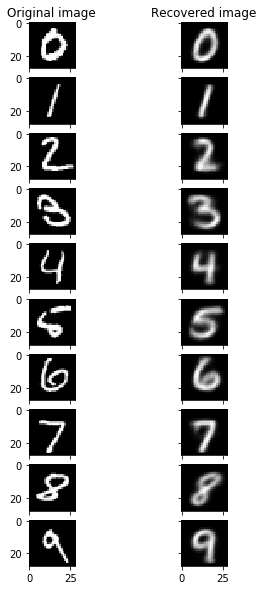

In [7]:
# switch game and all agents it incapsulates to the evaluation regime. During evaluation,
# Gumbel-Softmax-relaxed channel ceases being 'relaxed' and communicates one-hot vectors, representing
# individual symbols

game = game.eval()

from pylab import rcParams
rcParams['figure.figsize'] = 5, 10

f, ax = plt.subplots(10, 2, sharex=True, sharey=True)

for class_index, image_index in enumerate(image_indexes):
    original, label, _ = validation_dataset[image_index]
    label = torch.tensor([label]).cuda()
    
    with torch.no_grad():
        message = sender(original.cuda())
        recovered = receiver(message, label).cpu()
    
    ax[class_index][0].imshow(original.view(28, 28), cmap='gray')
    ax[class_index][1].imshow(recovered.view(28, 28), cmap='gray')
    
ax[0, 0].set_title("Original image")
ax[0, 1].set_title("Recovered image")

plt.show()

## Style transfer

What would happen if we, as Receiver's side information, pass another class? Hopefully, Receiver will output the images with the passed class, that shares the style of the image that is shown to Sender.

In Table generated below, all images within the single row share the same "style" communicated via the channel; the target class (passed to Receiver) iterates from 0 to 9 over the columns. The image in green is Receiver's reconstruction of the original image. Ideally, all images in every row have the same style as this green image.

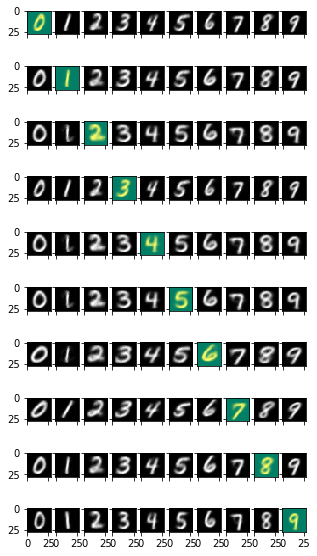

In [8]:
validation_dataset = validation_loader.dataset
sliced = validation_dataset.targets[-100:]
image_indexes = []

for class_index in range(10):
    to_take = (sliced == class_index).nonzero()[0]
    image_indexes.append(to_take.item())
image_indexes


from pylab import rcParams
rcParams['figure.figsize'] = 5, 10

f, ax = plt.subplots(10, 10, sharex=True, sharey=True)

for original_class_index, image_index in enumerate(image_indexes):
    for target_class_index in range(10):
        original, *other = validation_dataset[image_index]
        label = torch.tensor([target_class_index]).cuda()

        with torch.no_grad():
            message = sender(original.cuda())
            recovered = receiver(message, label).cpu()
        cmap = 'summer' if original_class_index == target_class_index else 'gray'
        ax[original_class_index][target_class_index].imshow(recovered.view(28, 28), cmap=cmap)
    
plt.show()

On comparing 8th (green 7, very inclined-to-right) and 10th (green 9, straight) rows, we see that the style is indeed captured to some extent.